In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [6]:
!pip install seaborn

# **Exploratory Data Analysis**

In [7]:
# Load in df
df = pd.read_csv('stats.csv')
df.head()

,"last_name, first_name",player_id,year,ab,pa,home_run,strikeout,walk,k_percent,bb_percent,...,b_swinging_strike,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Beltré, Adrian",134181,2017,340,389,17,52,39,13.4,10.0,...,122,0.384,0.358,36.1,5.8,32.5,97.066970,92.551073,18.7,46.8
1,"Beltrán, Carlos",136860,2017,467,509,14,102,33,20.0,6.5,...,146,0.283,0.284,29.4,4.6,31.0,97.251447,92.653848,19.8,47.9
2,"Werth, Jayson",150029,2017,252,289,10,69,35,23.9,12.1,...,92,0.311,0.329,33.2,8.2,40.7,99.992580,94.104058,21.9,38.6
3,"Arroyo, Bronson",276520,2017,26,29,0,10,0,34.5,0.0,...,10,0.135,0.210,36.8,0.0,0.0,89.654834,89.315833,26.2,50.0
4,"Dickey, R.A.",285079,2017,61,68,0,12,0,17.6,0.0,...,17,0.129,0.139,19.6,0.0,0.0,83.338039,88.117691,14.8,74.3


In [8]:
# Shape of dataset
rows, cols = df.shape[0], df.shape[0]

print(f'Number of Rows: {rows}')
print(f'Number of Columns: {cols}')

Number of Rows: 5419
Number of Columns: 5419


In [9]:
# All columns
print(df.columns)

Index(['last_name, first_name', 'player_id', 'year', 'ab', 'pa', 'home_run',
       'strikeout', 'walk', 'k_percent', 'bb_percent', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_rbi',
       'b_swinging_strike', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


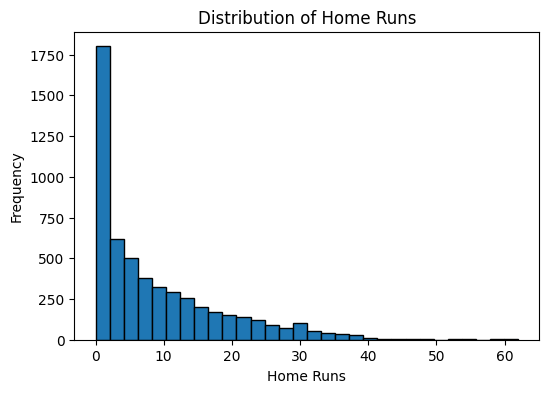

In [10]:
# distribution of target variable
plt.figure(figsize=(6,4))
plt.hist(df["home_run"], bins=30, edgecolor="black")
plt.xlabel("Home Runs")
plt.ylabel("Frequency")
plt.title("Distribution of Home Runs")
plt.show()

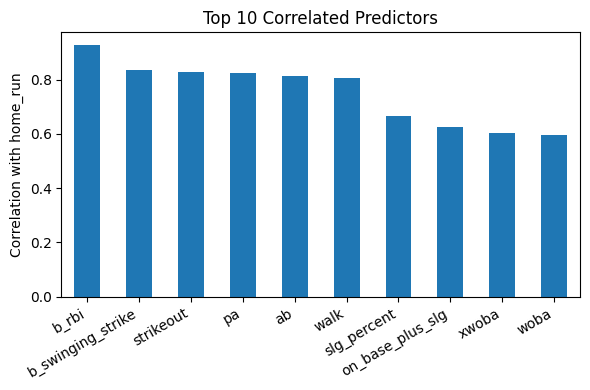

In [11]:
# top 10 correlations with home_run
corrs = df.corr(numeric_only=True)["home_run"].drop("home_run").sort_values(key=abs, ascending=False)
top10 = corrs.head(10)

plt.figure(figsize=(6,4))
top10.plot(kind="bar")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Correlation with home_run")
plt.title("Top 10 Correlated Predictors")
plt.tight_layout()
plt.show()


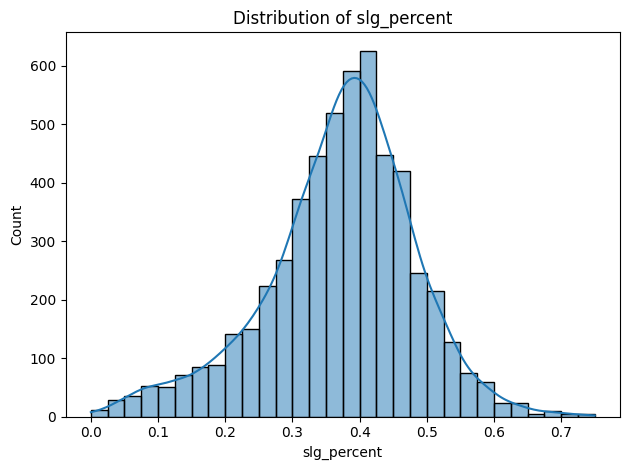

In [12]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['slg_percent'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'slg_percent'}")
plt.xlabel('slg_percent')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

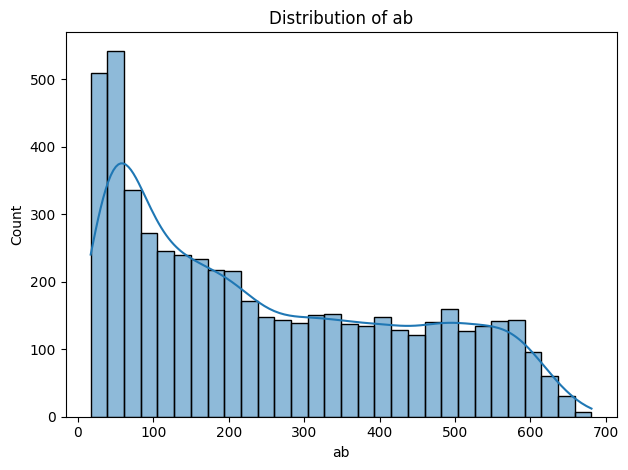

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['ab'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'plate appearances'}")
plt.xlabel('ab')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [23]:
# Filtering out rows where 'ab' (plate appearances) is less than or equal to 100
df = df[df['ab'] > 100]

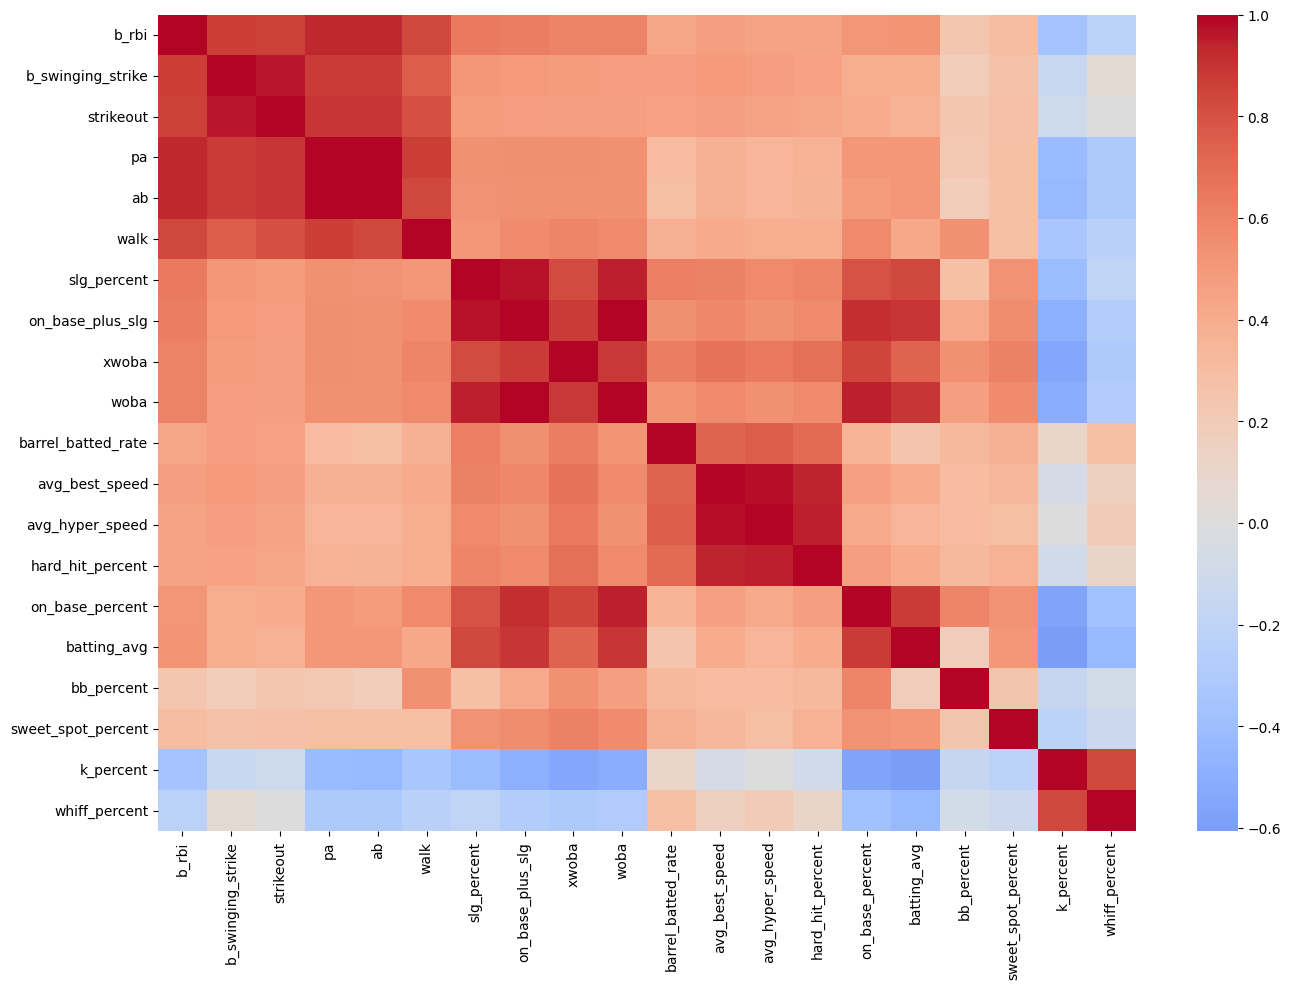

In [13]:
target = "home_run"
corr = df[numeric_cols].corr()
top20 = corr[target].abs().sort_values(ascending=False).index[1:21]
corr_top20 = corr.loc[top20, top20]
plt.figure(figsize=(14, 10))
sns.heatmap(corr_top20, annot=False, cmap="coolwarm", center=0)
plt.tight_layout()
plt.show()


## **Train/Test Split**

In [15]:
# remove non-numeric columns
id_cols = [col for col in df.columns if 'name' in col.lower() or 'id' in col.lower()]
df = df.drop(columns=id_cols, errors='ignore')

y = df['home_run']
X = df.drop(columns=['home_run'])

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4335, 22)
Test shape: (1084, 22)


# **Decision Tree**

### Model Variant 1: Only use the top 10 correlated features with `home_run`

In [26]:
# Only get top 10
correlations = df.corr()['home_run'].abs().sort_values(ascending=False)
top10 = correlations.index[1:11]

X_train_top10 = X_train[top10]
X_test_top10 = X_test[top10]

print("Top 10 correlated features:", list(top10))

Top 10 correlated features: ['b_rbi', 'b_swinging_strike', 'strikeout', 'pa', 'ab', 'walk', 'slg_percent', 'on_base_plus_slg', 'xwoba', 'woba']


In [27]:
# Decision Tree Regressor
dt_top10 = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

dt_top10.fit(X_train_top10, y_train)

# Train/test metrics
y_train_pred = dt_top10.predict(X_train_top10)
y_test_pred  = dt_top10.predict(X_test_top10)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test,  y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test,  y_test_pred)

metrics_table = pd.DataFrame({
    "Train": [train_r2, train_rmse, train_mae],
    "Test":  [test_r2,  test_rmse,  test_mae]
}, index=["R²", "RMSE", "MAE"])

print("Train/Test metrics (Variant 1):")
display(metrics_table)

# 5-fold cross-validation metrics
# R2
cv_r2_v1 = cross_val_score(
    dt_top10,
    X_train_top10,
    y_train,
    cv=5,
    scoring="r2"
)

# RMSE
cv_mse_v1 = -cross_val_score(
    dt_top10,
    X_train_top10,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_v1 = np.sqrt(cv_mse_v1)

# AIC on training data
n = len(y_train)
rss = np.sum((y_train - y_train_pred) ** 2)
p  = dt_top10.get_n_leaves()
aic_v1 = n * np.log(rss / n) + 2 * p

# Summary table for CV + AIC (Variant 1)
cv_aic_table_v1 = pd.DataFrame({
    "CV_R²_mean":      [cv_r2_v1.mean()],
    "CV_R²_std":       [cv_r2_v1.std()],
    "CV_RMSE_mean":    [cv_rmse_v1.mean()],
    "CV_RMSE_std":     [cv_rmse_v1.std()],
    "AIC_train":       [aic_v1]
}, index=["DecisionTree_V1_Top10"])

print("5-fold CV + AIC (Variant 1):")
display(cv_aic_table_v1)

Train/Test metrics (Variant 1):


,Train,Test
R²,0.916609,0.897509
RMSE,2.786719,3.150940
MAE,1.918584,2.133808


5-fold CV + AIC (Variant 1):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V1_Top10,0.895732,0.005996,3.111365,0.104064,8949.578423


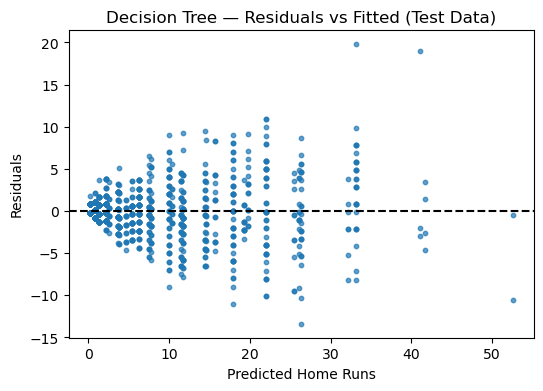

In [28]:
# Plot residual plot
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, s=10, alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Home Runs")
plt.ylabel("Residuals")
plt.title("Decision Tree — Residuals vs Fitted (Test Data)")
plt.show()

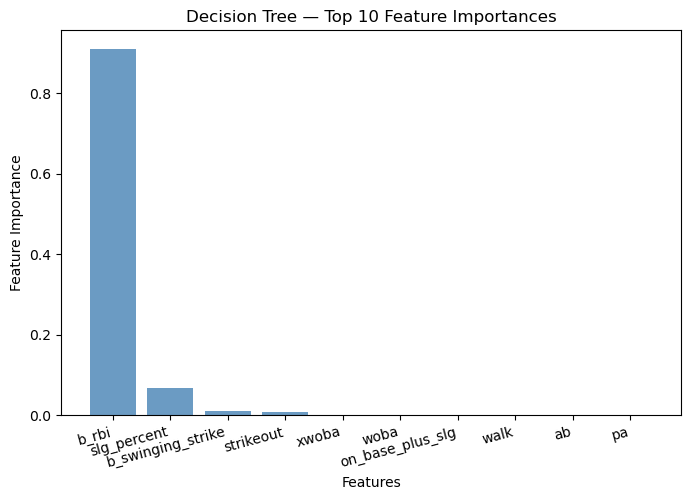

In [29]:
# Plot model feature importances
feature_importances = dt_top10.feature_importances_
orders_ft = np.argsort(feature_importances)[::-1]
features_sorted = [X_train_top10.columns[i] for i in orders_ft]
importances_sorted = feature_importances[orders_ft]

plt.figure(figsize=(8,5))
bars = plt.bar(features_sorted, importances_sorted, color='steelblue', alpha=0.8)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Decision Tree — Top 10 Feature Importances")
plt.xticks(rotation=15, ha="right")
plt.show()

### Model Variant 2: Tuned hyperparameters on all features

In [30]:
# Hyperparameter grid for DecisionTreeRegressor
dt_param_grid = {
    "max_depth": [None, 4, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["squared_error", "friedman_mse"],
    "splitter": ["best", "random"]
}

dt_base = DecisionTreeRegressor(random_state=42)

In [31]:
# Grid search with 5-fold CV optimizing MSE (we'll convert to RMSE)
dt_grid = GridSearchCV(estimator=dt_base, param_grid=dt_param_grid, cv=5)

dt_grid.fit(X_train, y_train)

print("Best parameters:", dt_grid.best_params_)

best_cv_mse = -dt_grid.best_score_
best_cv_rmse = np.sqrt(best_cv_mse)
print(f"Best CV RMSE: {best_cv_rmse:.3f}")

Best parameters: {'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best CV RMSE: nan


C:\Users\sohan\AppData\Local\Temp\ipykernel_50684\402736786.py:9: RuntimeWarning: invalid value encountered in sqrt
  best_cv_rmse = np.sqrt(best_cv_mse)


In [32]:
# Best tuned tree from grid search
dt_tuned = dt_grid.best_estimator_

# Predictions
y_train_pred_dt2 = dt_tuned.predict(X_train)
y_test_pred_dt2 = dt_tuned.predict(X_test)

# Metrics
train_r2_dt2 = r2_score(y_train, y_train_pred_dt2)
test_r2_dt2 = r2_score(y_test, y_test_pred_dt2)

train_rmse_dt2 = np.sqrt(mean_squared_error(y_train, y_train_pred_dt2))
test_rmse_dt2 = np.sqrt(mean_squared_error(y_test, y_test_pred_dt2))

train_mae_dt2 = mean_absolute_error(y_train, y_train_pred_dt2)
test_mae_dt2 = mean_absolute_error(y_test, y_test_pred_dt2)

print("Variant 2 – Tuned Hyperparameters (Decision Tree)")
print(f"Train R^2:  {train_r2_dt2:.3f}")
print(f"Test R^2:   {test_r2_dt2:.3f}")
print(f"Train RMSE: {train_rmse_dt2:.3f}")
print(f"Test RMSE:  {test_rmse_dt2:.3f}")
print(f"Train MAE:  {train_mae_dt2:.3f}")
print(f"Test MAE:   {test_mae_dt2:.3f}")


Variant 2 – Tuned Hyperparameters (Decision Tree)
Train R^2:  0.965
Test R^2:   0.924
Train RMSE: 1.801
Test RMSE:  2.714
Train MAE:  1.224
Test MAE:   1.850


In [33]:
# Structural complexity of the tuned tree
tree_depth_dt2 = dt_tuned.get_depth()
n_leaves_dt2 = dt_tuned.get_n_leaves()

print("Tuned tree depth:", tree_depth_dt2)
print("Number of leaves:", n_leaves_dt2)


Tuned tree depth: 8
Number of leaves: 210


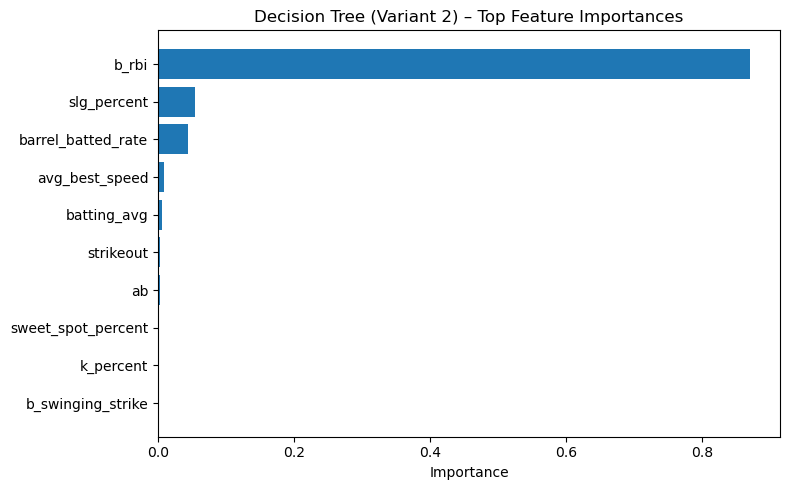

,feature,importance
11,b_rbi,0.870803
8,slg_percent,0.054871
16,barrel_batted_rate,0.044608
18,avg_best_speed,0.008177
7,batting_avg,0.005861
3,strikeout,0.002846
1,ab,0.002750
15,sweet_spot_percent,0.001771
5,k_percent,0.001350
12,b_swinging_strike,0.001209


In [34]:
# Feature importances from the tuned tree
importances_dt2 = dt_tuned.feature_importances_
feature_names = X_train.columns

# Put into DataFrame and sort
fi_dt2 = pd.DataFrame({
    "feature": feature_names,
    "importance": importances_dt2
}).sort_values("importance", ascending=False)

# limit y to 10 columns
top_k = 10
fi_top_dt2 = fi_dt2.head(top_k)

plt.figure(figsize=(8, 5))
plt.barh(fi_top_dt2["feature"][::-1], fi_top_dt2["importance"][::-1])
plt.xlabel("Importance")
plt.title("Decision Tree (Variant 2) – Top Feature Importances")
plt.tight_layout()
plt.show()

fi_top_dt2


In [35]:
# 5-fold CV metrics for Variant 2
# R2
cv_r2_v2 = cross_val_score(
    dt_tuned,
    X_train,
    y_train,
    cv=5,
    scoring="r2"
)

# RMSE
cv_mse_v2 = -cross_val_score(
    dt_tuned,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_v2 = np.sqrt(cv_mse_v2)

# AIC computation
n2 = len(y_train)
rss2 = np.sum((y_train - y_train_pred_dt2) ** 2)
p2  = dt_tuned.get_n_leaves()
aic_v2 = n2 * np.log(rss2 / n2) + 2 * p2

# Summary table for Variant 2
cv_aic_table_v2 = pd.DataFrame({
    "CV_R²_mean":      [cv_r2_v2.mean()],
    "CV_R²_std":       [cv_r2_v2.std()],
    "CV_RMSE_mean":    [cv_rmse_v2.mean()],
    "CV_RMSE_std":     [cv_rmse_v2.std()],
    "AIC_train":       [aic_v2]
}, index=["DecisionTree_V2_Tuned"])

print("5-fold CV + AIC (Variant 2):")
display(cv_aic_table_v2)

5-fold CV + AIC (Variant 2):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V2_Tuned,0.921375,0.005616,2.699698,0.051549,5522.692774


In [36]:
# Combined CV + AIC comparison for Variant 1 and Variant 2
combined_cv_aic = pd.DataFrame({
    "CV_R²_mean":   [cv_r2_v1.mean(),      cv_r2_v2.mean()],
    "CV_R²_std":    [cv_r2_v1.std(),       cv_r2_v2.std()],
    "CV_RMSE_mean": [cv_rmse_v1.mean(),    cv_rmse_v2.mean()],
    "CV_RMSE_std":  [cv_rmse_v1.std(),     cv_rmse_v2.std()],
    "AIC_train":    [aic_v1,               aic_v2]
}, index=["V1_Top10", "V2_Tuned"])

print("Cross-validation + AIC comparison (5-fold):")
display(combined_cv_aic)

Cross-validation + AIC comparison (5-fold):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
V1_Top10,0.895732,0.005996,3.111365,0.104064,8949.578423
V2_Tuned,0.921375,0.005616,2.699698,0.051549,5522.692774


### Model Variant 3: Standardized Predictors

In [37]:
# Fit scaler on training predictors only
scaler_v3 = StandardScaler()
X_train_v3 = scaler_v3.fit_transform(X_train)
X_test_v3 = scaler_v3.transform(X_test)

In [38]:
# Fit a plain decision tree
dt_v3 = DecisionTreeRegressor(random_state=42)
dt_v3.fit(X_train_v3, y_train)

y_train_pred_v3 = dt_v3.predict(X_train_v3)
y_test_pred_v3 = dt_v3.predict(X_test_v3)

In [39]:
# Computed metrics
train_rmse_v3 = np.sqrt(mean_squared_error(y_train, y_train_pred_v3))
test_rmse_v3  = np.sqrt(mean_squared_error(y_test,  y_test_pred_v3))

train_mae_v3  = mean_absolute_error(y_train, y_train_pred_v3)
test_mae_v3   = mean_absolute_error(y_test,  y_test_pred_v3)

train_r2_v3   = r2_score(y_train, y_train_pred_v3)
test_r2_v3    = r2_score(y_test,  y_test_pred_v3)

metrics_v3 = pd.DataFrame({
    "Train_RMSE": [train_rmse_v3],
    "Test_RMSE":  [test_rmse_v3],
    "Train_MAE":  [train_mae_v3],
    "Test_MAE":   [test_mae_v3],
    "Train_R²":   [train_r2_v3],
    "Test_R²":    [test_r2_v3]
}, index=["V3_Standardized"])

display(metrics_v3)


,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R²,Test_R²
V3_Standardized,0.0,3.110214,0.0,2.03321,1.0,0.900141


In [40]:
# 5-fold CV metrics for Variant 3
# R²
cv_r2_v3 = cross_val_score(
    dt_v3,
    X_train_v3,
    y_train,
    cv=5,
    scoring="r2"
)

# RMSE
cv_mse_v3 = -cross_val_score(
    dt_v3,
    X_train_v3,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_v3 = np.sqrt(cv_mse_v3)

# AIC computation
n3   = len(y_train)
rss3 = np.sum((y_train - y_train_pred_v3) ** 2)
p3   = dt_v3.get_n_leaves()

if rss3 <= 0:
    aic_v3 = np.inf
else:
    aic_v3 = n3 * np.log(rss3 / n3) + 2 * p3

# Summary table for Variant 3
cv_aic_table_v3 = pd.DataFrame({
    "CV_R²_mean":      [cv_r2_v3.mean()],
    "CV_R²_std":       [cv_r2_v3.std()],
    "CV_RMSE_mean":    [cv_rmse_v3.mean()],
    "CV_RMSE_std":     [cv_rmse_v3.std()],
    "AIC_train":       [aic_v3]
}, index=["DecisionTree_V3_Standardized"])

print("5-fold CV + AIC (Variant 3):")
display(cv_aic_table_v3)


5-fold CV + AIC (Variant 3):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V3_Standardized,0.902557,0.006648,3.005711,0.055429,inf


In [41]:
# Combined 5-fold CV + AIC comparison for Variants 1, 2, and 3

combined_cv_aic = pd.DataFrame({
    "CV_R²_mean":   [cv_r2_v1.mean(),      cv_r2_v2.mean(),      cv_r2_v3.mean()],
    "CV_R²_std":    [cv_r2_v1.std(),       cv_r2_v2.std(),       cv_r2_v3.std()],
    "CV_RMSE_mean": [cv_rmse_v1.mean(),    cv_rmse_v2.mean(),    cv_rmse_v3.mean()],
    "CV_RMSE_std":  [cv_rmse_v1.std(),     cv_rmse_v2.std(),     cv_rmse_v3.std()],
    "AIC_train":    [aic_v1,               aic_v2,               aic_v3]
}, index=[
    "DecisionTree_V1_Top10",
    "DecisionTree_V2_Tuned",
    "DecisionTree_V3_Standardized"
])

print("Combined 5-fold CV + AIC (Variants 1, 2, 3):")
display(combined_cv_aic)

Combined 5-fold CV + AIC (Variants 1, 2, 3):


,CV_R²_mean,CV_R²_std,CV_RMSE_mean,CV_RMSE_std,AIC_train
DecisionTree_V1_Top10,0.895732,0.005996,3.111365,0.104064,8949.578423
DecisionTree_V2_Tuned,0.921375,0.005616,2.699698,0.051549,5522.692774
DecisionTree_V3_Standardized,0.902557,0.006648,3.005711,0.055429,inf


# **Multiple Linear Regression**

### Model Variant 1: FINDING THE BEST NUMBER OF FEATURES BASED ON TOP 10 CORRELATED with `home_run`

In [24]:
# TOP CORRELATED FEATURES 
corr_with_y = X_train.join(y_train).corr(numeric_only=True)['home_run'].drop('home_run')
corr_sorted = corr_with_y.sort_values(ascending=False)
k = 10
top_features = corr_sorted.head(k).index.tolist()
top_features

['b_rbi',
 'b_swinging_strike',
 'pa',
 'strikeout',
 'ab',
 'walk',
 'slg_percent',
 'on_base_plus_slg',
 'xwoba',
 'woba']

In [25]:
# Finding the best number of features from top 10 correlated features
results = []

for k in range(10, 0, -1):  
    feats = top_features[:k]
    lr = LinearRegression()
    lr.fit(X_train[feats], y_train)
    
    
    y_pred_train = lr.predict(X_train[feats])
    y_pred_test  = lr.predict(X_test[feats])
    
    
    rmse_train = mean_squared_error(y_train, y_pred_train)
    rmse_test  = mean_squared_error(y_test, y_pred_test)
    r2_train   = r2_score(y_train, y_pred_train)
    r2_test    = r2_score(y_test, y_pred_test)
    
    results.append({
        'k': k,
        'features': feats,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test
    })

cv_df = pd.DataFrame(results)
cv_df

,k,features,rmse_train,rmse_test,r2_train,r2_test
0,10,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",6.999972,7.857864,0.924833,0.918883
1,9,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",7.006372,7.857426,0.924764,0.918888
2,8,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",7.115298,7.849130,0.923595,0.918973
3,7,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",8.272207,9.468016,0.911171,0.902262
4,6,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",8.766008,9.878907,0.905869,0.898020
5,5,"[b_rbi, b_swinging_strike, pa, strikeout, ab]",8.960902,10.272979,0.903776,0.893952
6,4,"[b_rbi, b_swinging_strike, pa, strikeout]",9.576345,11.362762,0.897167,0.882702
7,3,"[b_rbi, b_swinging_strike, pa]",10.026387,11.629275,0.892335,0.879951
8,2,"[b_rbi, b_swinging_strike]",12.181986,13.871013,0.869188,0.856809
9,1,[b_rbi],12.557500,14.574701,0.865155,0.849545


In [19]:
best_row = cv_df.sort_values('rmse_test').iloc[0]
k_best = best_row['k']
best_row, k_best

(k                                                             8
 features      [b_rbi, b_swinging_strike, pa, strikeout, ab, ...
 rmse_train                                             7.115298
 rmse_test                                               7.84913
 r2_train                                               0.923595
 r2_test                                                0.918973
 Name: 2, dtype: object,
 np.int64(8))

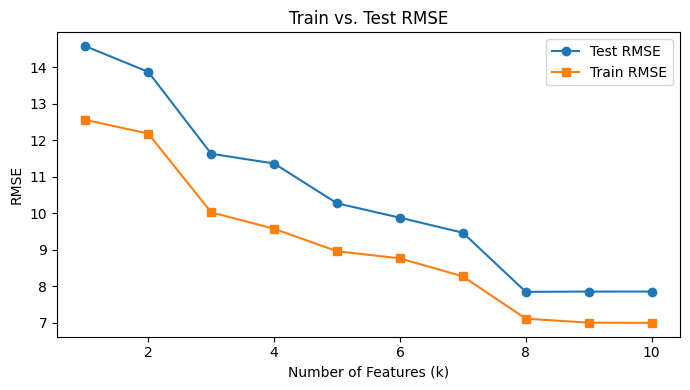

In [20]:
plt.figure(figsize=(7,4))
plt.plot(cv_df['k'], cv_df['rmse_test'], marker='o', label='Test RMSE')
plt.plot(cv_df['k'], cv_df['rmse_train'], marker='s', label='Train RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.title('Train vs. Test RMSE')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# OPTIMAL NUMBER OF FEATURES MODEL
summary_table = pd.DataFrame({
    'Metric': ['# of Features (k)', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Value': [
        k_best,
        round(best_row['rmse_train'], 3),
        round(best_row['rmse_test'], 3),
        round(best_row['r2_train'], 3),
        round(best_row['r2_test'], 3)
    ]
})
summary_table

,Metric,Value
0,# of Features (k),8.000
1,Train RMSE,7.115
2,Test RMSE,7.849
3,Train R²,0.924
4,Test R²,0.919


### Model Variant 2: Implementing Ridge Regression Using K-Fold Cross Validation

In [35]:
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "r2": "r2",
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "rmse": rmse_scorer    
}

cv_results = cross_validate(
    ridge_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

In [37]:
cv_table_per_fold = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R2": cv_results["test_r2"],
    "MSE": -cv_results["test_neg_mse"],
    "MAE": -cv_results["test_neg_mae"],
    "RMSE": -cv_results["test_rmse"]     
})

print("Cross-validation metrics per fold:")
print(cv_table_per_fold)

Cross-validation metrics per fold:
   Fold        R2       MSE       MAE      RMSE
0     1  0.927873  6.261391  1.827498  2.502277
1     2  0.927847  6.480113  1.895981  2.545607
2     3  0.924897  7.296304  1.987845  2.701167
3     4  0.934158  6.125477  1.807812  2.474970
4     5  0.940953  5.811865  1.753086  2.410781


In [30]:
ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

test_metrics = pd.DataFrame({
    "MSE": [mean_squared_error(y_test, y_pred)],
    "RMSE": [(mean_squared_error(y_test, y_pred)) ** 0.5],
    "MAE": [mean_absolute_error(y_test, y_pred)],
    "R2": [r2_score(y_test, y_pred)]
}, index=["Test Set"])

print("\nTest-set evaluation:")
print(test_metrics)


Test-set evaluation:
               MSE      RMSE       MAE       R2
Test Set  7.030846  2.651574  1.959316  0.92742


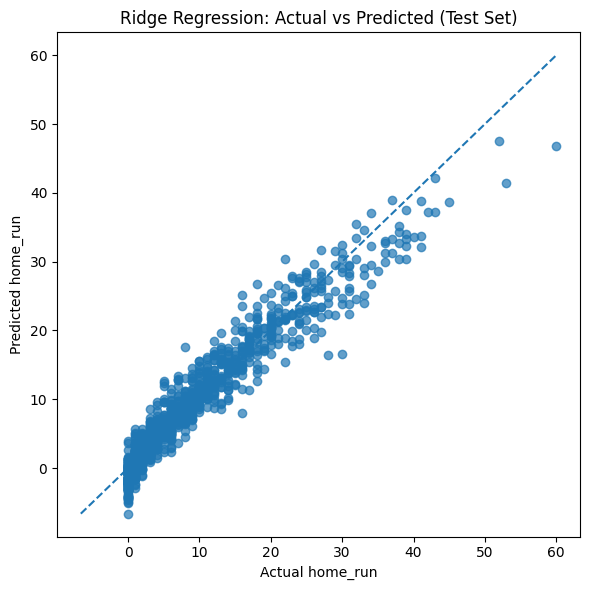

In [31]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual home_run")
plt.ylabel("Predicted home_run")
plt.title("Ridge Regression: Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.show()